# Aquire dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emnist

import torch 
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
def get_data():
    X, Y = emnist.extract_training_samples('letters')
    X_test, Y_test = emnist.extract_test_samples('letters')

    return X, Y- 1, X_test, Y_test - 1

In [3]:
X, m_Y, X_test, m_Y_test = get_data()

In [4]:
X.shape

(124800, 28, 28)

In [5]:
X = torch.tensor(np.array(X), dtype=torch.float)
X_test = torch.tensor(np.array(X_test), dtype=torch.float)

In [6]:
m = X.shape[0]
m

124800

In [7]:
Y = torch.zeros(m,26, dtype = torch.float)
Y_test = torch.zeros(X_test.shape[0],26, dtype = torch.long)
for i in range(0,m):
    Y[i, m_Y[i]] = 1
for i in range(0,X_test.shape[0]):
    Y_test[i, m_Y_test[i]] = 1

In [8]:
train_dataset = TensorDataset(X, Y)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [9]:
def show_img(i):
    plt.imshow(i)

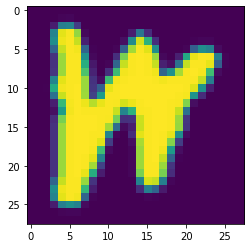

In [10]:
show_img(X[0])

In [11]:
#settings 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.01
batch_size = 10
epochs = 10

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5,padding=2)
        self.pool = nn.AvgPool2d((2,2),stride=(2,2))
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,26)
    
    def forward(self, x):
        x = torch.relu((self.conv1(x)))
        x = self.pool(x)
        x = torch.relu((self.conv2(x)))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net().to(device)

In [13]:
demo_tensor = torch.rand(1,1,28,28, device=device)
model(demo_tensor)

tensor([[-0.0304,  0.0838,  0.0282,  0.0574,  0.0508,  0.0048,  0.0687, -0.0102,
         -0.0547, -0.0201,  0.1510, -0.0047, -0.0025,  0.0554, -0.0355,  0.0540,
         -0.0101,  0.0767, -0.0559,  0.0281, -0.1116, -0.0130, -0.0400, -0.0243,
         -0.0406,  0.0774]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [16]:
losses = []

In [17]:
for epoch in range(epochs):
    running_loss = 0.0
    if epoch > (2/3*epochs):
        optimizer = optimizer = optim.SGD(model.parameters(), lr = learning_rate/10)
    print(f"Epoch {epoch+1}\n-------------------------------")
    size = len(train_dataloader.dataset)
    for batch, (x, y) in enumerate(train_dataloader):
        x = torch.unsqueeze(x ,1)
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 200 == 199:
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    losses.append(running_loss)
print('training finished')

Epoch 1
-------------------------------
[1,   200] loss: 1.724
[1,   400] loss: 0.793
[1,   600] loss: 0.597
[1,   800] loss: 0.513
[1,  1000] loss: 0.470
[1,  1200] loss: 0.421
[1,  1400] loss: 0.402
[1,  1600] loss: 0.367
[1,  1800] loss: 0.363
Epoch 2
-------------------------------
[2,   200] loss: 0.313
[2,   400] loss: 0.316
[2,   600] loss: 0.302
[2,   800] loss: 0.296
[2,  1000] loss: 0.297
[2,  1200] loss: 0.287
[2,  1400] loss: 0.288
[2,  1600] loss: 0.281
[2,  1800] loss: 0.272
Epoch 3
-------------------------------
[3,   200] loss: 0.264
[3,   400] loss: 0.247
[3,   600] loss: 0.245
[3,   800] loss: 0.256
[3,  1000] loss: 0.240
[3,  1200] loss: 0.233
[3,  1400] loss: 0.238
[3,  1600] loss: 0.240
[3,  1800] loss: 0.239
Epoch 4
-------------------------------
[4,   200] loss: 0.217
[4,   400] loss: 0.218
[4,   600] loss: 0.206
[4,   800] loss: 0.221
[4,  1000] loss: 0.222
[4,  1200] loss: 0.215
[4,  1400] loss: 0.219
[4,  1600] loss: 0.223
[4,  1800] loss: 0.213
Epoch 5
----

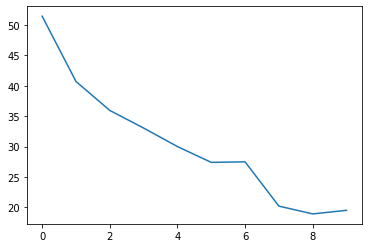

In [18]:
plt.plot(losses)

In [19]:
torch.save(model, "noice.pth")

In [20]:
count = 0

m_test = X_test.shape[0]

with torch.no_grad():
    for (x, y) in test_dataloader:
        x = torch.unsqueeze(x, 1)
        x, y = x.to(device), y.to(device)
        count += torch.sum(torch.argmax(model(x),1) == torch.argmax(y,1))
#accuracy
print(f'accuracy of model = {count/m_test * 100:.2f}%')

accuracy of model = 93.41%
